# Что посмотреть?
- distance = self.compute_distance_matrix(track_features, pred_features,track_boxes, boxes, metric_fn=cosine_distance)
    - cos = (-1,1) и как внутри это все визуализируется и согласуется с обычнми фичами = 255
- row_idx, col_idx = linear_assignment(distance)


#### Install and import Python libraries

In [2]:
%load_ext autoreload
%autoreload 2


In [3]:
import os
import sys

root_dir = ".."
sys.path.append(os.path.join(root_dir, "src"))


In [4]:
import matplotlib.pyplot as plt
import numpy as np
import time
import itertools
from tqdm.autonotebook import tqdm

import torch
from torch.utils.data import DataLoader

from mot.data.data_track import MOT16Sequences,MOT16Sequence
##from mot.data.data_obj_detect import MOT16ObjDetect
from mot.models.object_detector import FRCNN_FPN
from mot.tracker.base import Tracker
from mot.utils import (plot_sequence, evaluate_mot_accums, get_mot_accum,
                           evaluate_obj_detect, obj_detect_transforms)
from market.models import build_model

from scipy.optimize import linear_sum_assignment as linear_assignment

import motmetrics as mm
mm.lap.default_solver = 'lap'
%matplotlib inline
import collections

import numpy as np
import torch
import torch.nn.functional as F
import torchvision.transforms.functional as TF

import motmetrics as mm
from torchvision.ops.boxes import clip_boxes_to_image, nms

mm.lap.default_solver = 'lap'

import market.metrics as metrics

/tmp/ipykernel_7771/1385862480.py:5: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from tqdm.autonotebook import tqdm


In [32]:
seed = 43215
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
np.random.seed(seed)
torch.backends.cudnn.deterministic = True

os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"  # see issue #152
os.environ["CUDA_VISIBLE_DEVICES"] = "2"
np.set_printoptions(suppress=True)

_UNMATCHED_COST = 255.0


## Func

In [34]:
def cosine_distance(input1, input2):
    """Computes cosine distance.
    Args:
        input1 (torch.Tensor): 2-D feature matrix (m x feat).
        input2 (torch.Tensor): 2-D feature matrix (n x feat).
    Returns:
        torch.Tensor: distance matrix (m x n).
    """

    # Given that cos_sim(u, v) = dot(u, v) / (norm(u) * norm(v))
    #                          = dot(u / norm(u), v / norm(v))
    # We fist normalize the rows, before computing their dot products via transposition:
    norm1 = input1.norm(dim=1)[:, None]
    norm2 = input2.norm(dim=1)[:, None]
    input1_norm = input1 / norm1
    input2_norm = input2 / norm2
    cosine_similarity = torch.mm(input1_norm, input2_norm.t())
    distmat = 1 - cosine_similarity
    return distmat


### load detector

In [8]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")


In [9]:
obj_detect_model_file = os.path.join(root_dir, "models/faster_rcnn_fpn.model")
obj_detect_nms_thresh = 0.3

# object detector
obj_detect = FRCNN_FPN(num_classes=2, nms_thresh=obj_detect_nms_thresh)
obj_detect_state_dict = torch.load(
    obj_detect_model_file, map_location=lambda storage, loc: storage
)
obj_detect.load_state_dict(obj_detect_state_dict)
obj_detect.eval()
obj_detect = obj_detect.to(device)


/data/home/m.goldin/anaconda3/envs/tracking/lib/python3.10/site-packages/torchvision/models/_utils.py:135: UserWarning: Using 'backbone_name' and 'weights' as positional parameter(s) is deprecated since 0.13 and will be removed in 0.15. Please use keyword parameter(s) instead.
  warnings.warn(
/data/home/m.goldin/anaconda3/envs/tracking/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


## load reid model

In [10]:
model_path = root_dir + "/models/resnet34_reid_market.model"
reid_market_state_dict = torch.load(
    model_path, map_location=lambda storage, loc: storage
)
reid_model = build_model("resnet34", num_classes=751, loss="triplet", pretrained=True)
reid_model.load_state_dict(reid_market_state_dict)
reid_model = reid_model.to(device)


### load dataset

In [11]:
seq_name = "MOT16-02"
data_dir = os.path.join(root_dir, "data/MOT16")
seq = MOT16Sequence(data_dir, seq_name=seq_name)


## func

In [12]:
def cosine_distance(input1, input2):
    """Computes cosine distance.
    Args:
        input1 (torch.Tensor): 2-D feature matrix (m x feat).
        input2 (torch.Tensor): 2-D feature matrix (n x feat).
    Returns:
        torch.Tensor: distance matrix (m x n).
    """

    # Given that cos_sim(u, v) = dot(u, v) / (norm(u) * norm(v))
    #                          = dot(u / norm(u), v / norm(v))
    # We fist normalize the rows, before computing their dot products via transposition:
    norm1 = input1.norm(dim=1)[:, None]
    norm2 = input2.norm(dim=1)[:, None]
    input1_norm = input1 / norm1
    input2_norm = input2 / norm2
    cosine_similarity = torch.mm(input1_norm, input2_norm.t())
    distmat = 1 - cosine_similarity
    return distmat


In [13]:
class Track:
    """This class contains all necessary for every individual track."""

    def __init__(self, box, score, track_id, feature=None, inactive=0):
        self.id = track_id
        self.box = box
        self.score = score
        self.feature = collections.deque([feature])
        self.inactive = inactive
        self.max_features_num = 10

    def add_feature(self, feature):
        """Adds new appearance features to the object."""
        self.feature.append(feature)
        if len(self.feature) > self.max_features_num:
            self.feature.popleft()

    def get_feature(self):
        if len(self.feature) > 1:
            feature = torch.stack(list(self.feature), dim=0)
        else:
            feature = self.feature[0].unsqueeze(0)
        return feature.mean(0, keepdim=False)

    def __repr__(self):
        return f"track_id = {self.id} score = {self.score:.2f} bbox = {self.box}"


# reidTracker class

In [14]:
class ReIDHungarianTracker(Tracker):
    def add(self, new_boxes, new_scores, new_features):
        """Initializes new Track objects and saves them."""
        num_new = len(new_boxes)
        for i in range(num_new):
            self.tracks.append(
                Track(new_boxes[i], new_scores[i], self.track_num + i, new_features[i])
            )
        self.track_num += num_new

    def reset(self, hard=True):
        self.tracks = []
        # self.inactive_tracks = []

        if hard:
            self.track_num = 0
            self.results = {}
            self.im_index = 0

    def step(self, frame):
        """This function should be called every timestep to perform tracking with a blob
        containing the image information.
        """
        # object detection
        boxes, scores = self.obj_detect.detect(frame["img"])

        self.data_association(boxes, scores, frame["img"])

        # results
        for t in self.tracks:
            if t.id not in self.results.keys():
                self.results[t.id] = {}
            self.results[t.id][self.im_index] = np.concatenate(
                [t.box.cpu().numpy(), np.array([t.score])]
            )

        self.im_index += 1

    def get_crop_from_boxes(self, boxes, frame, height=256, width=128):
        """Crops all persons from a frame given the boxes.

        Args:
                boxes: The bounding boxes.
                frame: The current frame.
                height (int, optional): [description]. Defaults to 256.
                width (int, optional): [description]. Defaults to 128.
        """
        person_crops = []
        norm_mean = [0.485, 0.456, 0.406]  # imagenet mean
        norm_std = [0.229, 0.224, 0.225]  # imagenet std
        for box in boxes:
            box = box.to(torch.int32)
            res = frame[:, :, box[1] : box[3], box[0] : box[2]]
            res = F.interpolate(res, (height, width), mode="bilinear")
            res = TF.normalize(res[0, ...], norm_mean, norm_std)
            person_crops.append(res.unsqueeze(0))

        return person_crops

    def compute_reid_features(self, model, crops):
        f_ = []
        model.eval()
        with torch.no_grad():
            for data in crops:
                img = data.cuda()
                features = model(img)
                features = features.cpu().clone()
                f_.append(features)
            f_ = torch.cat(f_, 0)
            return f_

    def compute_distance_matrix(
        self, track_features, pred_features, track_boxes, boxes, metric_fn, alpha=0.0
    ):
        UNMATCHED_COST = 255.0

        # Build cost matrix.
        distance_iou = mm.distances.iou_matrix(
            track_boxes.numpy(), boxes.numpy(), max_iou=0.5
        )

        appearance_distance = metrics.compute_distance_matrix(
            track_features, pred_features, metric_fn=metric_fn
        )
        appearance_distance = appearance_distance.numpy() * 0.5
        # return appearance_distance

        assert np.alltrue(appearance_distance >= -0.1)
        assert np.alltrue(appearance_distance <= 1.1)

        combined_costs = alpha * distance_iou + (1 - alpha) * appearance_distance

        # Set all unmatched costs to _UNMATCHED_COST.
        distance = np.where(np.isnan(distance_iou), UNMATCHED_COST, combined_costs)
        return distance, appearance_distance, distance_iou

    def data_association(self, boxes, scores, frame):
        crops = self.get_crop_from_boxes(boxes, frame)
        pred_features = self.compute_reid_features(reid_model, crops).cpu().clone()
        if self.tracks:
            track_ids = [t.id for t in self.tracks]
            track_boxes = torch.stack([t.box for t in self.tracks], axis=0)
            track_features = torch.stack([t.get_feature() for t in self.tracks], axis=0)

            # This will use your similarity measure. Please use cosine_distance!
            distance, appearance_distance, distance_iou = self.compute_distance_matrix(
                track_features,
                pred_features,
                track_boxes,
                boxes,
                metric_fn=cosine_distance,
            )
            distance_list.append(distance)
            appearance_distance_list.append(appearance_distance)
            distance_iou_list.append(distance_iou)
            # Perform Hungarian matching.
            row_idx, col_idx = linear_assignment(distance)
            row_ids_list.append(row_idx)
            col_ids_list.append(col_idx)
            track_ids_list.append(track_ids)

            remove_track_ids = []
            seen_track_ids = []
            seen_box_idx = []

            for track_idx, box_idx in zip(row_idx, col_idx):
                costs = distance[track_idx, box_idx]
                internal_track_id = track_ids[track_idx]
                seen_track_ids.append(internal_track_id)
                if costs == _UNMATCHED_COST:
                    remove_track_ids.append(internal_track_id)
                else:
                    self.tracks[track_idx].box = boxes[box_idx]
                    self.tracks[track_idx].add_feature(pred_features[box_idx])
                    seen_box_idx.append(box_idx)

            unseen_track_ids = set(track_ids) - set(seen_track_ids)
            remove_track_ids.extend(list(unseen_track_ids))
            self.tracks = [t for t in self.tracks if t.id not in remove_track_ids]

            # row_idx and col_idx are indices into track_boxes and boxes.
            # row_idx[i] and col_idx[i] define a match.
            # distance[row_idx[i], col_idx[i]] define the cost for that matching.

            #  If the costs are equal to _UNMATCHED_COST, it's not a
            # match. Be careful with override self.tracks, as past tracks will
            # be gone.

            #  Please update the feature of a track by using add_feature:
            # self.tracks[my_track_id].add_feature(pred_features[my_feat_index])
            # Reason: We use the mean feature from the last 10 frames for ReID.

            new_boxes_idx = set(range(len(boxes))) - set(seen_box_idx)
            new_boxes = [boxes[i] for i in new_boxes_idx]
            new_scores = [scores[i] for i in new_boxes_idx]
            new_features = [pred_features[i] for i in new_boxes_idx]
            self.add(new_boxes, new_scores, new_features)
        else:
            # No tracks exist.
            self.add(boxes, scores, pred_features)


## TMP files to save 

In [15]:
print(f"Tracking: {seq}")
data_loader = DataLoader(seq, batch_size=1, shuffle=False)
firstn_loader = itertools.islice(data_loader, 10)


Tracking: MOT16-02


In [16]:
tracker = ReIDHungarianTracker(obj_detect)


In [17]:
print("pred_features.shape =  torch.Size([15, 512])")


pred_features.shape =  torch.Size([15, 512])


In [18]:
distance_list = []
appearance_distance_list = []
distance_iou_list = []
row_ids_list = []
col_ids_list = []
track_ids_list = []

tracker.reset()

for frame in tqdm(firstn_loader):
    tracker.step(frame)

results = tracker.get_results()
print(f"Tracks found: {len(results)}")


10it [00:01,  6.54it/s]

Tracks found: 19


# describe insights insides

In [20]:
print(f"distance_list contain results dist, len(distance_list) = {len(distance_list)}")
print(
    f"appearance_distance_list contain reid dist, len(appearance_distance_list) = {len(appearance_distance_list)}"
)
print(
    f"distance_iou_list contain iou intersection dist, len(distance_iou_list) = {len(distance_iou_list)}"
)


distance_list contain results dist, len(distance_list) = 9
appearance_distance_list contain reid dist, len(appearance_distance_list) = 9
distance_iou_list contain iou intersection dist, len(distance_iou_list) = 9


In [21]:
seq_num = -5
dist = distance_list[seq_num]
row_ids = row_ids_list[seq_num]
col_ids = col_ids_list[seq_num]
track_ids = track_ids_list[seq_num]


In [22]:
row_ids, col_ids


(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15]),
 array([ 0,  1,  5,  2,  6,  7,  4,  8,  3, 12,  9, 13, 11, 14, 15, 10]))

In [23]:
for track_idx, box_idx in zip(row_ids, col_ids):
    costs = dist[track_idx, box_idx]
    # internal_track_id = track_ids[track_idx]
    print(f"{track_idx=}, {box_idx=}, {costs=}")


track_idx=0, box_idx=0, costs=0.0008519589900970459
track_idx=1, box_idx=1, costs=0.0052249133586883545
track_idx=2, box_idx=5, costs=0.0008480250835418701
track_idx=3, box_idx=2, costs=0.002408623695373535
track_idx=4, box_idx=6, costs=0.0021851956844329834
track_idx=5, box_idx=7, costs=0.0048639774322509766
track_idx=6, box_idx=4, costs=0.007331192493438721
track_idx=7, box_idx=8, costs=0.005859017372131348
track_idx=8, box_idx=3, costs=0.0018106400966644287
track_idx=9, box_idx=12, costs=0.006718754768371582
track_idx=10, box_idx=9, costs=0.001518845558166504
track_idx=11, box_idx=13, costs=0.06050693988800049
track_idx=12, box_idx=11, costs=0.010566294193267822
track_idx=13, box_idx=14, costs=0.004970133304595947
track_idx=14, box_idx=15, costs=0.008618533611297607
track_idx=15, box_idx=10, costs=0.003927171230316162


In [28]:
import matplotlib.pyplot as plt


def plot_hist(d, bins, title):
    n, bins, patches = plt.hist(x=d, bins=bins, color="#0504aa", alpha=0.7, rwidth=0.85)
    plt.grid(axis="y", alpha=0.75)
    plt.xlabel("Value")
    plt.ylabel("Frequency")
    plt.title(title)
    maxfreq = n.max()
    # Set a clean upper y-axis limit.
    plt.ylim(ymax=np.ceil(maxfreq / 10) * 10 if maxfreq % 10 else maxfreq + 10)


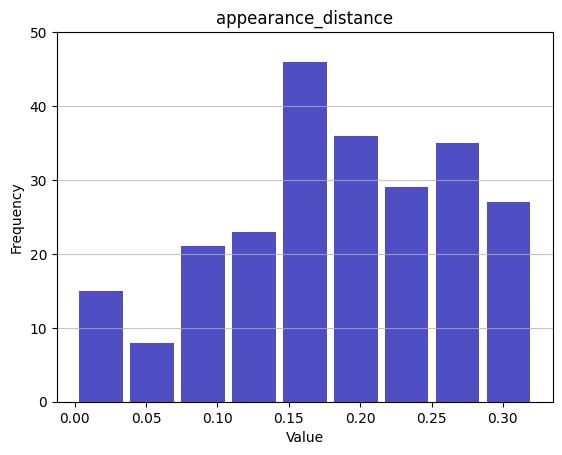

In [29]:
plot_hist(appearance_distance_list[0].ravel(), bins="auto", title="appearance_distance")


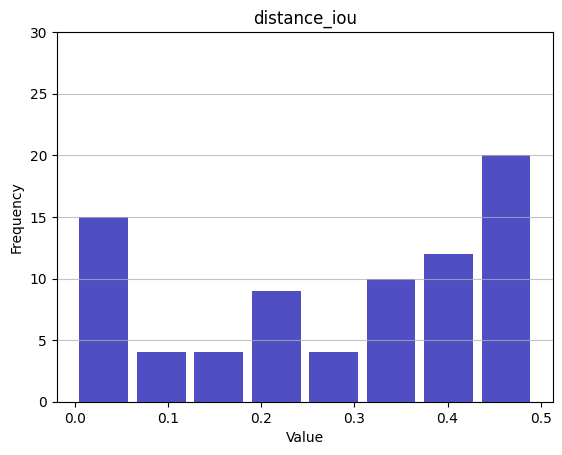

In [30]:
plot_hist(distance_iou_list[0].ravel(), bins="auto", title="distance_iou")


## Example sequences